# Assignment 3

## Importing Libraries

In [1]:
import os
import matplotlib.pyplot as plt
from typing import Tuple
import torch
from torch import nn
from torch.nn import functional as F
from dataclasses import dataclass
from src.utils import load_text, set_seed, configure_device
%matplotlib inline

## Configuration

In [2]:
@dataclass
class MLPConfig:
    root_dir: str = os.getcwd() + "/../../"
    dataset_path: str = "data/raw/names.txt"
    device: torch.device = torch.device('cpu')  # Automatic device configuration

    # Tokenizer
    vocab_size: int = 0  # Set later
    
    # Model
    context_size: int = 3
    d_embed: int = 16
    d_hidden: int = 64
    
    # Training
    val_size: float = 0.1
    val_interval: int = 1000
    batch_size: int = 32
    lr: float = 2e-4
    max_steps: int = 10000

    seed: int = 101

## Reproducibility

In [3]:
set_seed(MLPConfig.seed)
generator = torch.Generator().manual_seed(MLPConfig.seed)

Random seed set to 101


## Device

In [4]:
MLPConfig.device = configure_device()

Running on 1 NVIDIA GeForce RTX 4080 SUPER GPU(s)


## Tokenizer

In [5]:
chars = [chr(i) for i in range(97, 123)]  # all alphabet characters
chars.insert(0, ".")  # Add special token
MLPConfig.vocab_size = len(chars)
str2idx = {char: idx for idx, char in enumerate(chars)}
idx2str = {idx: char for char, idx in str2idx.items()}

## Dataset

In [6]:
names = load_text(MLPConfig.root_dir + MLPConfig.dataset_path).splitlines()

Loaded text data from /mnt/c/Users/cheir/GitHub/LLM101/notebooks/Assignments/../../data/raw/names.txt (length: 228145 characters).


In [7]:
print(f"Number of names: {len(names)}")

Number of names: 32033


## Preprocessing

### Task 1: Train-Validation split

Using all the data for training leads to overfitting.

Implement a function to split the text into training and validation sets. 


In [8]:
def split_names(_names: str, val_size: float) -> Tuple[str, str]:
    """
    Split text into training and validation sets.

    Args:
        _names (str): The data to split.
        val_size (float): Size of the validation set.

    Returns:
        Tuple[str, str]: Training and validation data.
    """
    if val_size <= 0 or val_size >= 1:
        raise ValueError(f"Invalid validation size: {val_size}")
    # ------------------
    # Write your implementation here.
    split_idx = int(len(_names) * (1 - val_size))
    train_text, val_text = _names[:split_idx], _names[split_idx:]
    # ------------------
    return train_text, val_text

In [9]:
train_names, val_names = split_names(names, MLPConfig.val_size)
print(f"Training set size: {len(train_names)}")
print(f"Validation set size: {len(val_names)}")

Training set size: 28829
Validation set size: 3204


In [10]:
def get_dataloader(_names):
    inputs, targets = [], []

    for name in _names:
        context = [0] * MLPConfig.context_size
        
        for char in name + ".":
            idx = str2idx[char]
            inputs.append(context)
            targets.append(idx)
            context = context[1:] + [idx]  # Shift the context by 1 character

    inputs = torch.tensor(inputs)
    targets = torch.tensor(targets)
    
    return inputs, targets

In [11]:
train_inputs, train_targets = get_dataloader(train_names)
val_inputs, val_targets = get_dataloader(val_names)

print(f"Training inputs shape: {train_inputs.shape}")
print(f"Training targets shape: {train_targets.shape}")
print(f"Validation inputs shape: {val_inputs.shape}")
print(f"Validation targets shape: {val_targets.shape}")

Training inputs shape: torch.Size([205411, 3])
Training targets shape: torch.Size([205411])
Validation inputs shape: torch.Size([22735, 3])
Validation targets shape: torch.Size([22735])


## Model

### Task 2: `nn.Module`.

PyTorch provides a module called `nn.Module` for defining models. Instead of defining every layer as a separate tensor, we can wrap it all up in a class. This provides better organization and encapsulation.

[PyTorch Documentation](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)

Implement a class `MLP` that inherits from `nn.Module`.
(Hint: You can use `nn.Embedding` and `nn.Linear`)


In [12]:
class MLP(nn.Module):
    # ------------------
    # Write your implementation here.
    def __init__(self, vocab_size, context_size, d_embed, d_hidden):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_embed)
        self.linear1 = nn.Linear(context_size * d_embed, d_hidden, bias=True)
        self.linear2 = nn.Linear(d_hidden, vocab_size, bias=True)
        
    def forward(self, x):  # x: (batch_size, context_size)
        x_embed = self.embedding(x)  # (batch_size, context_size, d_embed)
        x_embed = x_embed.view(x_embed.size(0), -1)  # (batch_size, context_size * d_embed)
        x = F.relu(self.linear1(x_embed))  # (batch_size, d_hidden)
        x = self.linear2(x)  # (batch_size, vocab_size)
        return x
    # ------------------
    # Note: do not include softmax in the forward pass since it is already included in the loss function.

In [13]:
# Initialize the model
mlp = MLP(MLPConfig.vocab_size, MLPConfig.context_size, MLPConfig.d_embed, MLPConfig.d_hidden)
mlp.to(MLPConfig.device) # Move the model to the device
print(mlp)
print("Number of parameters:", sum(p.numel() for p in mlp.parameters()))

# Example forward pass
example_input = train_inputs[:2]
example_input = example_input.to(MLPConfig.device)  # Move the data to the device
print(f"Input shape: {example_input.shape}")
print(f"Output shape: {mlp(example_input).shape}")

MLP(
  (embedding): Embedding(27, 16)
  (linear1): Linear(in_features=48, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=27, bias=True)
)
Number of parameters: 5323
Input shape: torch.Size([2, 3])
Output shape: torch.Size([2, 27])


## Training

### Task 3: Implement the training loop.

In [14]:
def train(model):
    steps = []
    train_losses = []
    val_losses = []
    
    # Define the optimizer
    # ------------------
    # Write your implementation here.
    optimizer = torch.optim.SGD(mlp.parameters(), lr=MLPConfig.lr)
    # ------------------
    
    for step in range(MLPConfig.max_steps):
        # Training
        ## Sample batch
        idx = torch.randperm(len(train_inputs))[:MLPConfig.batch_size]
        x, y = train_inputs[idx], train_targets[idx]
        x, y = x.to(MLPConfig.device), y.to(MLPConfig.device)  # Move the data to the device
        
        ## Forward pass
        # ------------------
        # Write your implementation here.
        optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        
        ## Backward pass
        loss.backward()
        optimizer.step()
        # ------------------
        
        # Validation
        if step % MLPConfig.val_interval == 0:
            # Validation loss
            with torch.no_grad():
                val_logits = mlp(val_inputs.to(MLPConfig.device))
                val_loss = F.cross_entropy(val_logits, val_targets.to(MLPConfig.device)).item()
                val_losses.append(val_loss)
            
        # Logging
        steps.append(step)
        train_losses.append(loss.item())
        if step % 1000 == 0:
            print(f"Step {step}: Loss = {loss.item()}")

    # Plot the loss
    plt.figure()
    plt.plot(steps, train_losses, label="Train")
    plt.plot(steps[::MLPConfig.val_interval], val_losses, label="Validation")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    # Visualization of the embedding matrix
    plt.figure(figsize=(10, 10))
    plt.scatter(mlp.embedding.weight[:,0], mlp.embedding.weight[:,1])
    for i in range(MLPConfig.vocab_size):
        plt.text(mlp.C.weight[i,0], mlp.C.weight[i,1], idx2str[i])
    plt.grid('minor')

Step 0: Loss = 3.304964542388916
Step 1000: Loss = 3.29408597946167
Step 2000: Loss = 3.169219732284546
Step 3000: Loss = 3.0842254161834717
Step 4000: Loss = 3.1652920246124268
Step 5000: Loss = 3.0806188583374023
Step 6000: Loss = 3.037827968597412
Step 7000: Loss = 3.1085705757141113
Step 8000: Loss = 2.75146746635437
Step 9000: Loss = 2.9651405811309814


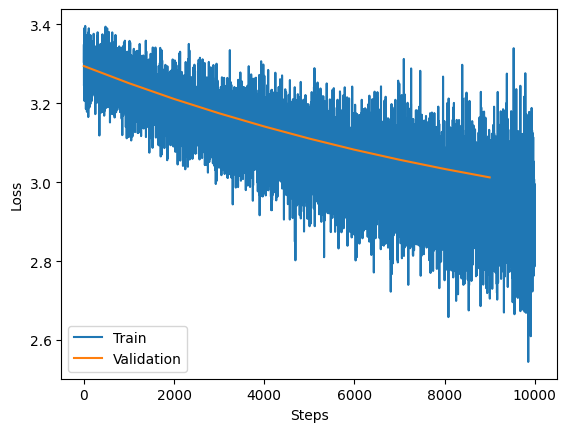

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

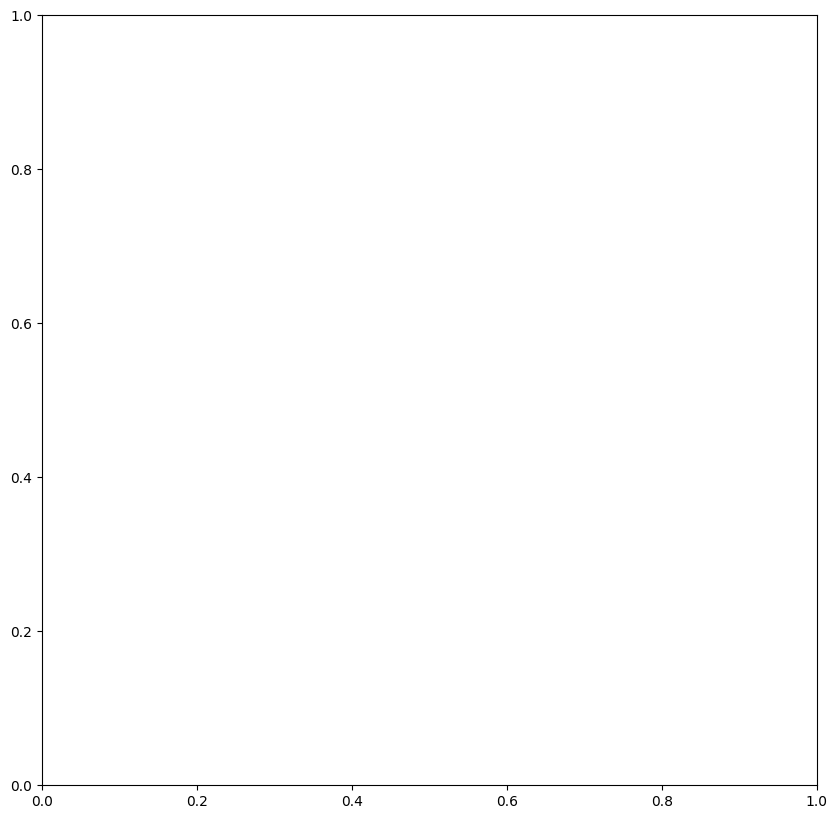

In [15]:
train(mlp)

## Inference

In [ ]:
def generate_name():
    new_name = []
    context = [0] * MLPConfig.context_size
    
    while True:
        # forward pass
        x = torch.tensor(context).unsqueeze(0).to(MLPConfig.device)
        logits = mlp(x)
        
        # sample
        probs = F.softmax(logits, dim=-1)
        idx = torch.multinomial(probs, num_samples=1).item()
        
        # update context
        new_name.append(idx2str[idx])
        context = context[1:] + [idx]
        
        # break if "."
        if idx == 0:
            break
        
    return "".join(new_name)

In [ ]:
for _ in range(5):
    print(generate_name())

## Extra Credit

Change the model configuration and hyperparameters to achieve the following:

Get the lowest **validation loss** as possible.

Rules:
- Do not change the random seed.